# Deep Learning from Udacity (Google)
## Assignment 1
Use notMNIST dataset to classify numbers with kdb, q and python
<br>For starters, we will import the python libraries that we need
Adapted from: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb

In [1]:
\c 200 200
plt:.p.import[`matplotlib.pyplot];
np:.p.import[`numpy];
pd:.p.import[`pandas];
os:.p.import[`os];
sys:.p.import[`sys];
tarfile:.p.import[`tarfile];
display:.p.import[`IPython.display][`:display];
Image:.p.import[`IPython.display][`:Image];
skimage:.p.import[`skimage];
imageio:.p.import[`imageio];

### Download functionality
After importing, we have to declare local python callbacks that we need.
<br> In this example, we need a download progress hook to monitor the download progress, this is not necessary but useful to show that the function is running
<br>
<br> The hook is declared in python while the download functionality is embedpy

In [3]:
/%declare download hook to monitor download progress
p)last_percent_reported=None
p)def download_progress_hook(count, blockSize, totalSize):
  import sys
  global last_percent_reported

  percent = int(count * blockSize * 100 / totalSize)
 
  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

download_progress_hook:.p.get[`download_progress_hook]

In [4]:
url:"http://yaroslavvb.com/upload/notMNIST/"
dataStore:`:DeepLearning
if[()~key dataStore;
    -1"Deep Learning Folder is missing, creating it now";
    system "mkdir DeepLearning"]
notMNISTLarge:`notMNIST_large.tar.gz
notMNISTSmall:`notMNIST_small.tar.gz

downloadFile:{[file;dateStore;url] 
    urllib:.p.import[`urllib][`:request];
    fileDir:` sv dataStore,file;
    url:url,string file;
    -1"Check if ",1_string[fileDir]," exists?";
    $[()~key fileDir;
        [-1"File is missing, initialise download";
        urllib[`:urlretrieve][url;1_string fileDir;`reporthook pykw download_progress_hook];
        /0N! 1_string fileDir;
        /httpGet[]
        /filename:urlretrieve[url;1_string fileDir][];
        -1"\nDownload Complete!";];
        -1"File is present, skip download";
        ]
    }



In [5]:
downloadFile[notMNISTLarge;dataStore;url];
-1"\n";
downloadFile[notMNISTSmall;dataStore;url];

Check if DeepLearning/notMNIST_large.tar.gz exists?
File is present, skip download


Check if DeepLearning/notMNIST_small.tar.gz exists?
File is present, skip download


### Untaring of data
After the files are downloaded into the directory we want them in, we will have to untar the data
<br> Note that the directory structure is known before hand.
<br> If it was not known, we will have toe use recursive key to know its structure dynamically.

In [6]:
/Note This can be done with system tar -xzf in linux

unTarFile:{[file;dateStore]
    fileNoTar: `$first "." vs string file;
    fileDir:` sv dataStore,file;
    folderDir: 1_(first "." vs string fileDir),"/.";
    -1"Check if ",1_string[fileDir]," exists?";
    if[10=count childDir:key parentDir:` sv (folderDirQ:hsym `$-2_folderDir),fileNoTar;
        -1"Extracted Files Exists! \nSkipping Extraction for ",string file;
        :` sv' parentDir,/:childDir];
    if[file in key dateStore;
        -1"File exists, proceed to untar into ",-1_folderDir;
        -1"This will take a while, please be patient";
        tar:tarfile[`:open][1_string fileDir];
        tar[`:extractall][`path pykw folderDir];
        tar[`:close][];
        ];
    if[fileNoTar in key folderDirQ;
       $[10=count childDir:key parentDir;
            [-1"Extraction Completed! \nAll 10 Folders are Present";` sv' parentDir,/:childDir];
            -2"Extraction Failed! \nThere Are Missing Folders";
            ]
        ]
    
    }


In [7]:
notMNISTSmallFolders:unTarFile[notMNISTSmall;dataStore]
-1"\n";
notMNISTLargeFolders:unTarFile[notMNISTLarge;dataStore]

Check if DeepLearning/notMNIST_small.tar.gz exists?
Extracted Files Exists! 
Skipping Extraction for notMNIST_small.tar.gz


Check if DeepLearning/notMNIST_large.tar.gz exists?
Extracted Files Exists! 
Skipping Extraction for notMNIST_large.tar.gz


## Visualisation of Downloaded Data
We might want to randomly look at some of the image files which we have downloaded

In [21]:
3#notMNISTSmallFolders
3#notMNISTLargeFolders

randomSelectionA:1_'string ` sv' notMNISTSmallFolders[0],/:2?key notMNISTSmallFolders 0
randomSelectionB:1_'string ` sv' notMNISTSmallFolders[1],/:2?key notMNISTSmallFolders 1

display each Image each randomSelectionA;
display each Image each randomSelectionB;

`:DeepLearning/notMNIST_small/notMNIST_small/A`:DeepLearning/notMNIST_small/notMNIST_small/B`:DeepLearning/notMNIST_small/notMNIST_small/C


`:DeepLearning/notMNIST_large/notMNIST_large/A`:DeepLearning/notMNIST_large/notMNIST_large/B`:DeepLearning/notMNIST_large/notMNIST_large/C


## Load Image into DataSet

Each of the folder represent a specific letter with its image inside
<br>Each image is 28 X 28 in size, this represents 784 pixels with each image
<br>We would have to store each of this 784 pixels into a numerical dataset which we will be able to work on with tensorFlow later

In [9]:
/here we try to load the small image dataset with the help scikit image
.utils.path:{$[x~k:key x;x;11h=type k;raze (.z.s ` sv x,)each k;()]}
/note this func is highly recursive, do not perform on root, 
/this is useful is there is weird nesting but slow if we know the structure.
notMINSTLargeNest:`:DeepLearning/notMNIST_large/notMNIST_large
notMINSTLargeNest:notMINSTAlphabet!(` sv notMINSTLargeNest,) each notMINSTAlphabet:key notMINSTLargeNest
/this contains the nested directory of each alphabet
/going forward we need to load all the for each alphabet into a q table
3#notMINSTLargeNest

A| :DeepLearning/notMNIST_large/notMNIST_large/A
B| :DeepLearning/notMNIST_large/notMNIST_large/B
C| :DeepLearning/notMNIST_large/notMNIST_large/C


In [10]:
/load directories
/lazy implemetation of utils.path
/sequence of run is important as when we load the tables, q will cd into the folder

loadDir:{
        @[{value x;-1"Already contains paths ",string x};
        x;
        {x set .utils.path[(value -1_string x)`$-1#string x];-1"Stored ",string x;y}[x;]];
 };
loadDir each`$"notMINSTLargeNest",/:10#.Q.A;
(2#value @) each `$"notMINSTLargeNest",/:10#.Q.A

Stored notMINSTLargeNestA
Stored notMINSTLargeNestB
Stored notMINSTLargeNestC
Stored notMINSTLargeNestD
Stored notMINSTLargeNestE
Stored notMINSTLargeNestF
Stored notMINSTLargeNestG
Stored notMINSTLargeNestH
Stored notMINSTLargeNestI
Stored notMINSTLargeNestJ


:DeepLearning/notMNIST_large/notMNIST_large/A/ISBKYW1pcm9xdWFpICEudHRm.png :DeepLearning/notMNIST_large/notMNIST_large/A/IVNrZXRjaHkgVGltZXMgQm9sZC50dGY=.png
:DeepLearning/notMNIST_large/notMNIST_large/B/ISBKYW1pcm9xdWFpICEudHRm.png :DeepLearning/notMNIST_large/notMNIST_large/B/IVNrZXRjaHkgVGltZXMgQm9sZC50dGY=.png
:DeepLearning/notMNIST_large/notMNIST_large/C/ISBKYW1pcm9xdWFpICEudHRm.png :DeepLearning/notMNIST_large/notMNIST_large/C/IVNrZXRjaHkgVGltZXMgQm9sZC50dGY=.png
:DeepLearning/notMNIST_large/notMNIST_large/D/ISBKYW1pcm9xdWFpICEudHRm.png :DeepLearning/notMNIST_large/notMNIST_large/D/IVNrZXRjaHkgVGltZXMgQm9sZC50dGY=.png
:DeepLearning/notMNIST_large/notMNIST_large/E/ISBKYW1pcm9xdWFpICEudHRm.png :DeepLearning/notMNIST_large/notMNIST_large/E/IVNrZXRjaHkgVGltZXMgQm9sZC50dGY=.png
:DeepLearning/notMNIST_large/notMNIST_large/F/ISBKYW1pcm9xdWFpICEudHRm.png :DeepLearning/notMNIST_large/notMNIST_large/F/IVNrZXRjaHkgVGltZXMgQm9sZC50dGY=.png
:DeepLearning/notMNIST_large/notMNIST_large/G/ISBKYW

In [11]:
/create table to upsert data into
(`$"largeTable",/:10#.Q.A) set\: flip `alphabet`imgData!(();())
largeTableA

`largeTableA`largeTableB`largeTableC`largeTableD`largeTableE`largeTableF`largeTableG`largeTableH`largeTableI`largeTableJ


alphabet imgData
----------------


In [12]:
/define func to read in each image and store them as q table
imageIngestion:{[imgPath;t;alpha]
    /read in img with imageio
    @[{imgData:raze `float$imageio[`:imread][1_string x 0]`;
        /validation to ensure that image is 28x28
        $[784=count imgData;
            x[1] upsert (x 2;imgData);
            -1"imgPath ",string[x 0]," skipped"];
        };
        (imgPath;t;alpha);
        {-1"imgPath ",1_string[x]," couldn't be read, skipped ",.Q.s y}imgPath];    
    }


In [13]:
/note that this is a very expensive operation and can take up to 30 mins for the entire ingestion
/we will save the table down as a q table to make it efficient
/if table has been saved down, it will be skipped
ingestFunc:{[imgPath]
    alpha:last ` vs first ` vs first imgPath;
    t:`$"largeTable",string alpha;
    $[()~key toStore:` sv `:DeepLearning/notMNIST_large/flatTable,t;
     [-1"Start of Image Ingestion ",string t;
        imageIngestion[;t;alpha] each imgPath;
        -1"Saving Down Flat File to HDB";
        toStore set value t;
        ];
    -1"Flat table exist, skipping ingestion for ",string t];    
    } 

/running the ingestion function
(ingestFunc value @) each "notMINSTLargeNest",/:10#.Q.A;



Flat table exist, skipping ingestion for largeTableA
Flat table exist, skipping ingestion for largeTableB
Flat table exist, skipping ingestion for largeTableC
Flat table exist, skipping ingestion for largeTableD
Flat table exist, skipping ingestion for largeTableE
Flat table exist, skipping ingestion for largeTableF
Flat table exist, skipping ingestion for largeTableG
Flat table exist, skipping ingestion for largeTableH
Flat table exist, skipping ingestion for largeTableI
Flat table exist, skipping ingestion for largeTableJ


In [14]:
-1"Following Tables are in local drive: ",.Q.s keptTable:keptTable where (keptTable:`#key `:DeepLearning/notMNIST_large/flatTable)like "*largeTable*";
(`$'10#.Q.A)!(count get @)each ` sv' `:DeepLearning/notMNIST_large/flatTable,/:keptTable

Following Tables are in local drive: `largeTableA`largeTableB`largeTableC`largeTableD`largeTableE`largeTableF`largeTableG`largeTableH`largeTableI`largeTableJ



A| 52909
B| 52911
C| 52912
D| 105822
E| 52912
F| 52912
G| 52912
H| 52912
I| 52912
J| 52911


## Normalisation of Data
After the long and challenging process to ingest all the image data, now we have proper q hdb table with the image arrays to work with.

To speed up machine learning process, we will adopt normalisation of data which is to subtract the mean followed by the std deviation.

There are other methods of data manipulation which includes scaling to (0,1) but normalisation is chosen in this study.

In [2]:
/get table into memory, heavy operation
\l DeepLearning/notMNIST_large/flatTable

In [3]:
/standardise data
/due to massize table, we will obtain each table means and std first 
tabDict:tables[`]!10#();
{data:raze (value x)`imgData;![`tabDict;();0b;enlist[x]!enlist(avg data;dev data)]} each tables`;
tabDict

largeTableA| 94.79621 112.9958
largeTableB| 125.5714 115.8953
largeTableC| 91.22419 112.1506
largeTableD| 112.8712 116.1901
largeTableE| 109.6758 115.5001
largeTableF| 95.47628 114.0078
largeTableG| 103.3817 113.7912
largeTableH| 110.0268 115.8291
largeTableI| 135.3505 119.5691
largeTableJ| 88.39362 113.1324


In [4]:
{![x;();0b;enlist[`imgData]!enlist(%;(-;`imgData;((tabDict;enlist x);0));((tabDict;enlist x);1))]} each tables`
/parse allow use to build flexible functional statement when needed
/parse "update imgData:(imgData-tabDict[`largeTableA]0)%tabDict[`largeTableA]1 from largeTableA"
/here we use kdb capability to handle large data to standardise the data
(3#value @) each tables`

`largeTableA`largeTableB`largeTableC`largeTableD`largeTableE`largeTableF`largeTableG`largeTableH`largeTableI`largeTableJ


+`alphabet`imgData!(`A`A`A;(-0.838936 -0.838936 -0.838936 -0.838936 -0.8212362 -0.8300861 -0.838936 -0.838936 -0.4849404 0.06375276 0.523947 0.7805938 0.683245 0.5150971 0.285 -0.2194437 -0.6088388..
+`alphabet`imgData!(`B`B`B;(-1.08349 -0.7901219 0.184896 0.1503821 -0.8591497 -1.08349 -1.074862 -1.08349 -1.08349 -1.08349 -1.08349 -1.08349 -1.08349 -1.08349 -1.08349 -1.08349 -1.08349 -1.08349 -..
+`alphabet`imgData!(`C`C`C;(-0.813408 -0.813408 -0.813408 -0.813408 -0.813408 -0.813408 -0.7955748 -0.8044914 -0.813408 -0.813408 -0.6974924 -0.3497457 0.2030824 0.595412 0.6399949 0.5419125 0.3279..
+`alphabet`imgData!(`D`D`D;(-0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9714356 -0.9..
+`alphabet`imgData!(`E`E`E;(-0.9495727 -0.9495727 -0.9495727 -0.9495727 -0.9495727 -0.9409147 -0.9235987 -0.9495727 -0.9495727 -0.9495727 -0.6119107 -0.1184047 0.2885214 0.5915514 0.6088674 0.34046..


In [5]:
/check mean and std of each largeTable to show that standardisation was applied properly
statsStandardisedTable:raze {select avg raze imgData, dev raze imgData from value x} each tables`
statsStandardisedTable

imgData        imgData1
-----------------------
6.110237e-013  1       
1.12524e-012   1       
-6.452146e-013 1       
4.442727e-013  1       
-7.416703e-013 1       
-8.031316e-014 1       
7.484703e-013  1       
8.375953e-013  1       
2.476911e-012  1       
2.447311e-013  1       


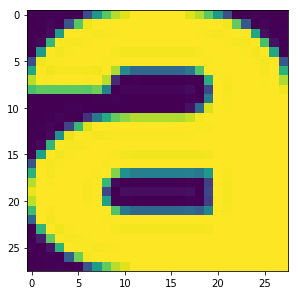

In [6]:
/plot data to show that data didnt change much
/check how to plot data points into matlabplot, good reference will be kdb q notebook
test:exec 1?imgData from largeTableA 

plt[`:imshow]"f"$28 cut test[0];
plt[`:show][];

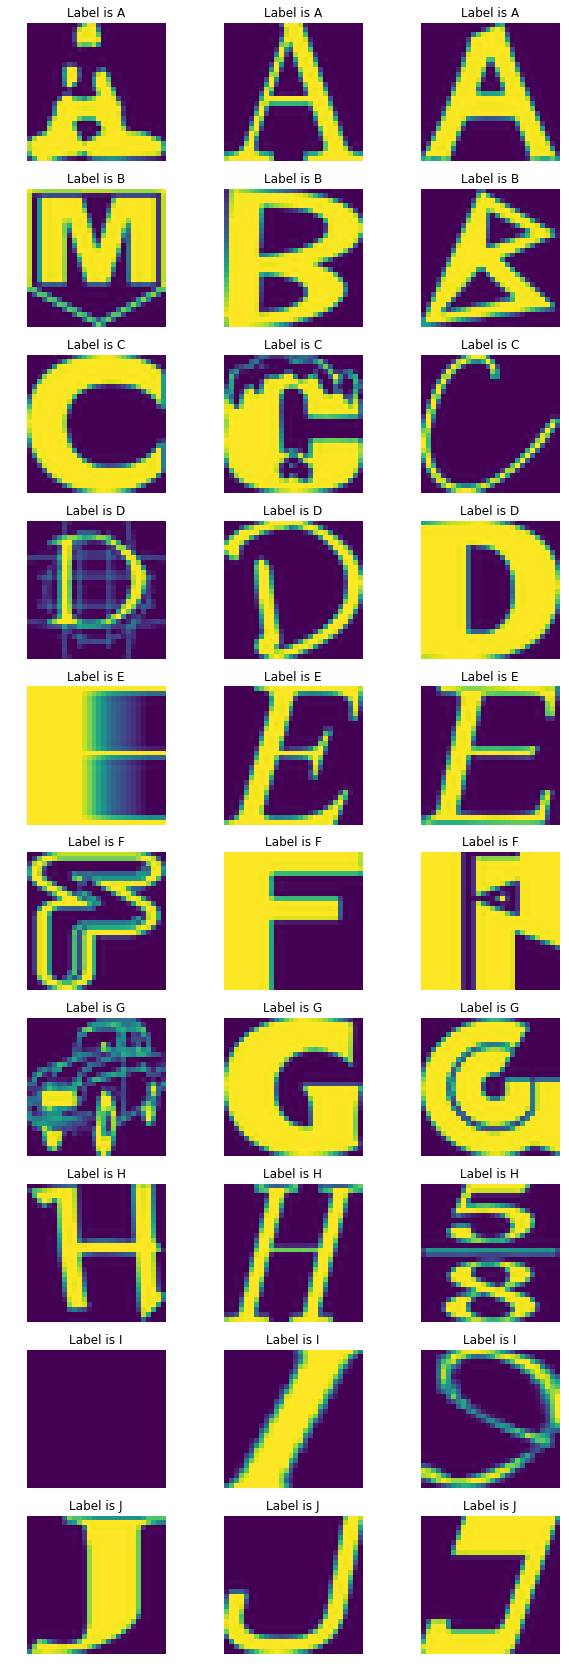

In [92]:
subplots:plt[`:subplots][10;3];
fig:subplots[@;0];
axarr:subplots[@;1];
fig[`:set_size_inches;10;30];
pltData:raze value each "3 ? largeTable",/:10#.Q.A;

{position:cross[til 10;til 3];
    /Get into subplot array
    box:axarr[`$":__getitem__"].p.eval","sv string position x;
    box[`:imshow]"f"$28 cut pltData[`imgData]x;
    box[`:axis]`off;
    box[`:set_title]"Label is ",string pltData[`alphabet]x;
 }each til 30;

plt[`:show][];

## Building of Training and Testing Set
Now that we have verified that standardisation did not change our dataset, we are able to start shuffling the data into 2 basket.

The 2 baskets are the training and testing set in machine learning. Also for completeness, there is the validation set which can be used to fine tune parameters in machine learning before testing them

In [8]:
/lets look at the ratio of data
value each "exec count i from largeTable",/:10#.Q.A
/
we will see that all the data set has approximately 52000 data, we will seek to split them into 80:20 of 52000
taking .8*52000 will get us 41600
hence the ratio will be 41600:10400
due to lazy implementation of randomness, we will create the random index which will select from the table and then deletes
\
randIndex:-41600?52000;
trainingSet:raze value each "select from largeTable",/:(10#.Q.A),\:" where i in randIndex";
testingSet:raze value each"-10400?delete from largeTable",/:(10#.Q.A),\:" where i in randIndex";

52909 52911 52912 105822 52912 52912 52912 52912 52912 52911


## Machine Learning

With our training and testing set, we can now use them to implement various machine learning technique to predict into the unknown alphabets

In [23]:
/import skilearn python library
lr:.p.import[`sklearn.linear_model][`:LogisticRegression]
/from sklearn.cross_validation import train_test_split
metrics:.p.import[`sklearn][`:metrics]
/from sklearn.cross_validation import cross_val_score

In [59]:
/train logisticRegression
/with standard specifications, solver = 'lbfgs' (supposedly faster), mutliclass='ovr'

/setting up data

trainingSetRandIndex:neg[trainingSetRandIndex]?trainingSetRandIndex:count trainingSet;
testingSetRandIndex:neg[testingSetRandIndex]?testingSetRandIndex:count testingSet;

In [63]:
/setting up data into training, testing and validation
actualTrainingSetIndex:(`int$0.8*count trainingSetRandIndex)#trainingSetRandIndex
validationSetRandIndex:(`int$0.8*count trainingSetRandIndex)_trainingSetRandIndex

trainingSetPyX:trainingSet[`imgData] actualTrainingSetIndex;
trainingSetPyY:trainingSet[`alphabet] actualTrainingSetIndex;

validationSetPyX:trainingSet[`imgData] validationSetRandIndex;
validationSetPyY:trainingSet[`alphabet] validationSetRandIndex;

testingSetPyX:testingSet[`imgData] testingSetRandIndex;
testingSetPyY:testingSet[`alphabet] testingSetRandIndex;

In [64]:
/training model with data from q
model:lr[`solver pykw "saga"];
model:model[`:fit][trainingSetPyX;trainingSetPyY];
/model[`score][trainingSetPyX;trainingSetPyY]

C:\Users\Limgu\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [65]:
/with the trained model lets predict the test set
predictions:`$model[`:predict][testingSetPyX][`:tolist][]`;
-1"Accuracy Evaluation from Prediction";
-1"Quick View of predictions against actual test data";
-1 .Q.s predictions;
-1 .Q.s testingSetPyY;
-1"Accuracy Score from off the shelf logistic regression";
(count where testingSetPyY=predictions)%count testingSetPyY

Accuracy Evaluation from Prediction
Quick View of predictions against actual test data
`J`A`A`B`E`I`F`H`J`F`A`J`E`E`F`B`I`C`F`I`F`H`D`J`J`C`B`I`D`A`G`H`I`G`I`B`D`G`C`H`D`E`I`A`C`C`G`J`F`E`D`H`E`D`J`C`H`C`H`A`B`J`H`H`G`C`H`J`A`G`G`C`F`C`G`I`J`G`C`D`H`E`E`G`I`H`I`E`F`E`G`G`A`F`H`A`A`G`..

`J`A`A`D`E`I`B`H`J`I`A`J`H`C`F`B`I`C`F`A`B`H`D`J`H`C`B`I`D`A`G`D`I`G`I`B`D`G`C`H`D`E`I`A`C`C`G`D`B`E`F`H`E`D`J`C`A`C`H`H`B`J`H`J`E`C`B`J`A`G`G`C`F`B`C`I`J`G`C`A`H`E`E`G`I`H`E`E`F`E`G`G`D`F`H`A`A`G`..

Accuracy Score from off the shelf logistic regression


0.8173462


From the score above, in vanilla form we have obtained a average accurarcy of 81.73%. This might be able to be improved if we use validation set to improve the predictive power of our model with customisation.

Also another issue we face could be due to the fact that convergence was unable to be reached give the sag solver. We might want to try saga when there is another time to try

In [66]:
/get the index of the errors then we get the data and plot them against the actual label and the wrong label
(testingSetPyY;predictions)[;where testingSetPyY<>predictions]

D B I H C A B H D D B F A H J E B B C A E D F D C G A D J A H G A J D I G B B H B G D B C D F I H E D J A E G A B J E E D G H C A G G B A J H A A A D F F E G H C J B F A C J G C F G A E I F C A J E..
B F F E E I F J H J F D H A H G H C G D I A D J E E F I D B A E C D F F J E E A F J B I G E I D F I G I J H F D E I A C H J I A I C B G J I I I I F H H G C J I G B C I F G A D E I I G G H E E J I C..


Given the quick look at a vanilla model, we attempt to look at the actual image where the errors occur

In [72]:
errorCheckData:`testingSetPyX`testingSetPyY`predictions!(testingSetPyX;testingSetPyY;predictions)[;where testingSetPyY<>predictions];
1#'errorCheckData


testingSetPyX| -0.9714356 -0.9542224 -0.7046315 -0.446434 -0.1968431 0.09578079 0.422831 0.6896351 0.8273404 0.9478326 1.085538 1.197424 1.162997 1.059718 0.9736524 0.8789799 0.7929141 0.5691429 0...
testingSetPyY| D                                                                                                                                                                                     ..
predictions  | B                                                                                                                                                                                     ..



But now we will seek to look at the root cause of the error and possibly able to come up with better strategy which might overcome the wrong prediction

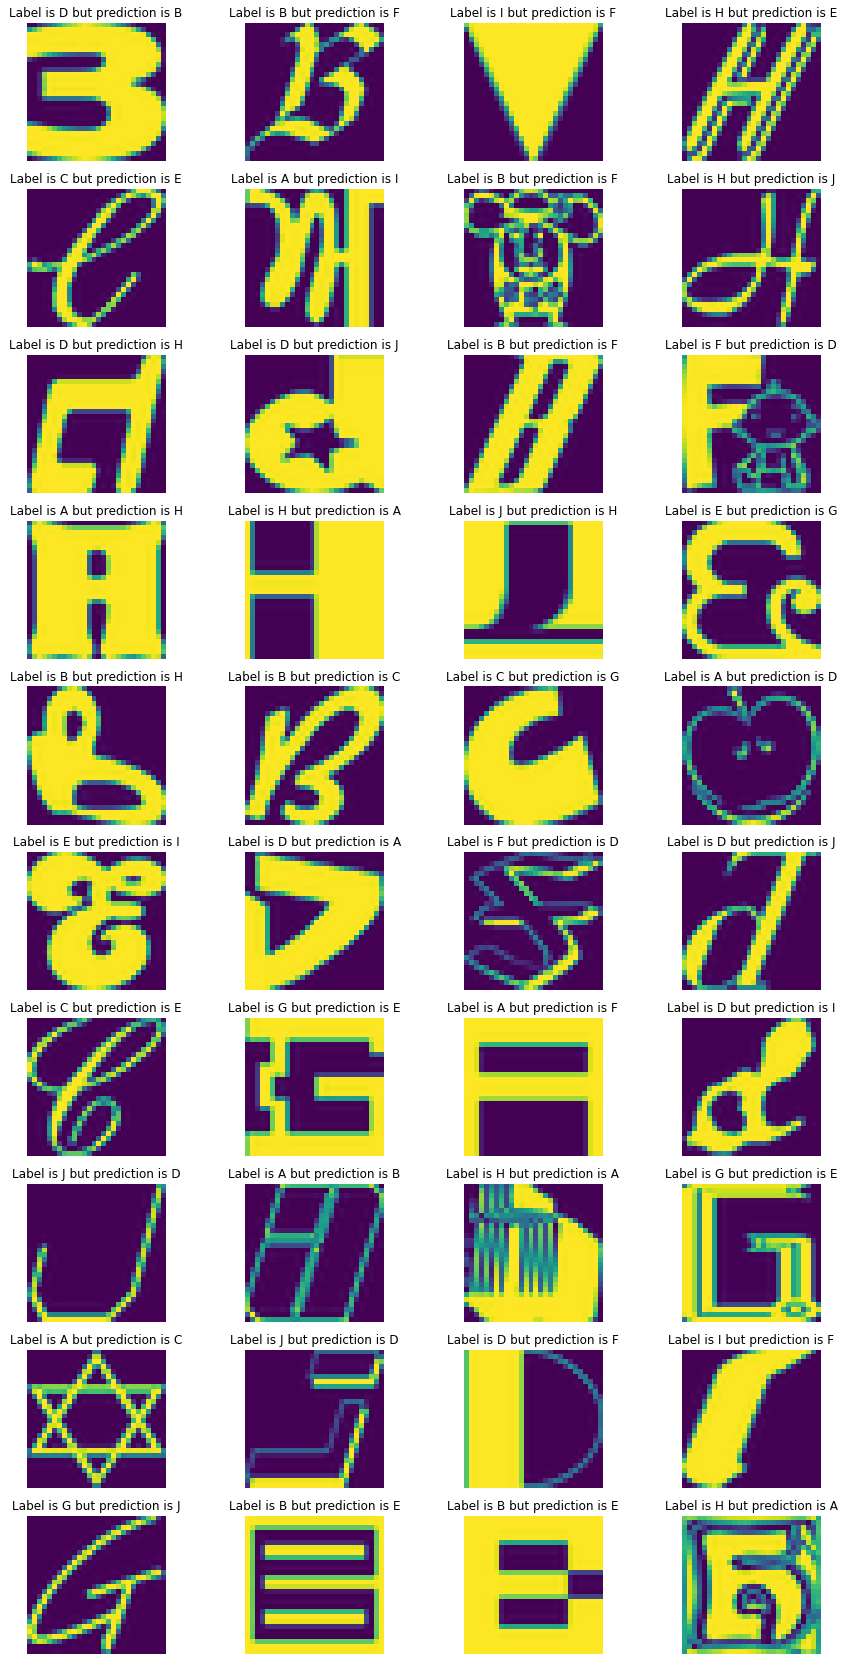

In [101]:
subplots:plt[`:subplots][10;4];
fig:subplots[@;0];
axarr:subplots[@;1];
fig[`:set_size_inches;15;30];

{position:cross[til 10;til 4];
    /Get into subplot array
    box:axarr[`$":__getitem__"].p.eval","sv string position x;
    box[`:imshow]"f"$28 cut errorCheckData[`testingSetPyX]x;
    box[`:axis]`off;
    box[`:set_title]"Label is ",(string errorCheckData[`testingSetPyY]x)," but prediction is ",string errorCheckData[`predictions]x;
 }each til 40;

plt[`:show][];


## Conclusion
Given the mere accuracy of 80%, there are still many other methods we can apply.
But this notebook seeks to quickly address the use of q with python and the machine learning techniques available to us.

Just look at the wrongly predicted comparison, we see that even if the image is misleading, a human eye would be able to pinpoint most of them out. Hence the failure of the model to correctly predict would be due to a weak model due to non customisation.

Here the following can be suggested:
1.  Use neural network with convolution and pooling layer
2.  Use SVM as an alternative method
3.  Use the validation set to pick a better model after using multi machine learning technique to identify each alphabet
